In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D
from keras.models import Model
import cv2 as op
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
import kagglehub

# plt.style.available
plt.style.use('seaborn-v0_8')
np.__version__

2025-03-04 13:47:34.769291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741092454.845185   71028 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741092454.871248   71028 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 13:47:34.995419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'1.26.4'

In [2]:
!pip install albumentations

In [3]:
PATH = os.path.join(kagglehub.dataset_download('therealoise/bean-disease-dataset'), "Bean_Dataset")
os.listdir(PATH)

['healthy', 'angular_leaf_spot', 'bean_rust']

In [4]:
labels = {
    'bean_rust' : 0,
    'healthy' : 1,
    'angular_leaf_spot' : 2
}

label_index, filepath = [], []

for label in os.listdir(PATH):
    for file in tqdm(os.listdir(PATH + "/" + label)):
        label_index.append(labels[label])
        filepath.append(PATH + "/" + label + "/" +file)

print(len(label_index), len(filepath))

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

990 990


In [5]:
df = pd.DataFrame({
    'filepath' : filepath,
    'label_index' : label_index
})

df = df.sample(frac = 1).reset_index().drop('index', axis = 1)
df

filepath  label_index
0    /home/martin/.cache/kagglehub/datasets/thereal...            1
1    /home/martin/.cache/kagglehub/datasets/thereal...            0
2    /home/martin/.cache/kagglehub/datasets/thereal...            1
3    /home/martin/.cache/kagglehub/datasets/thereal...            0
4    /home/martin/.cache/kagglehub/datasets/thereal...            0
..                                                 ...          ...
985  /home/martin/.cache/kagglehub/datasets/thereal...            0
986  /home/martin/.cache/kagglehub/datasets/thereal...            2
987  /home/martin/.cache/kagglehub/datasets/thereal...            2
988  /home/martin/.cache/kagglehub/datasets/thereal...            0
989  /home/martin/.cache/kagglehub/datasets/thereal...            2

[990 rows x 2 columns]

label_index
1    330
0    330
2    330
Name: count, dtype: int64

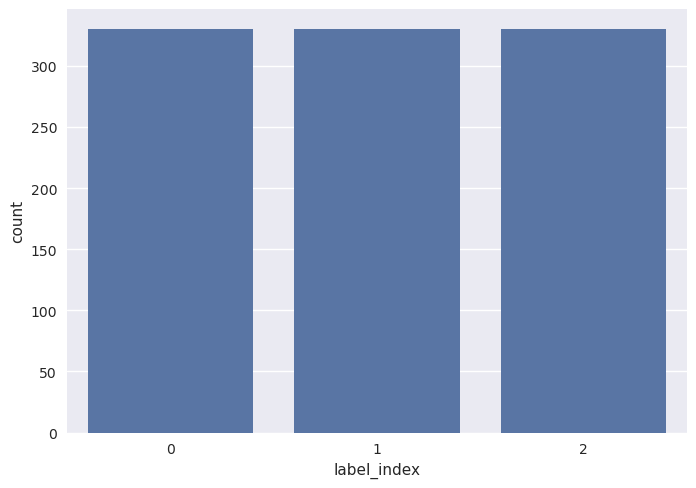

In [6]:
sea.countplot(x = 'label_index', data = df)
df['label_index'].value_counts()

In [9]:
img = plt.imread(df.iloc[400,0])
img.shape

(500, 500, 3)

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size = 0.2)
df_val, df_test = train_test_split(df_val, test_size = 0.3)
df_train.shape, df_val.shape, df_test.shape

((792, 2), (138, 2), (60, 2))

In [11]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.Blur(blur_limit = 3, p = 0.5), 
])

/home/martin/miniconda/lib/python3.12/site-packages/torch/utils/_pytree.py:173: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [27]:
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(labels)
BATCH_SIZE = 64

def map_function(img, label, training):
    img = plt.imread(img.decode())[:, :, :3]
    img = op.resize(img, (224, 224))
    if training:
        img = transform(image = img)['image']
    img = preprocess_input(img)
    label = to_categorical(label, num_classes = NUM_CLASSES)
    return img, np.float32(label)

def create_dataset(df, training = False):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'], df['label_index']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, label : tf.numpy_function(
                    map_function, [img, label, training], [tf.float32, tf.float32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda img, label: (tf.ensure_shape(img, IMG_SHAPE), tf.ensure_shape(label, [NUM_CLASSES])))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [28]:
train_dataset = create_dataset(df_train, True)
val_dataset = create_dataset(df_val)
test_dataset = create_dataset(df_test)

In [29]:
a, b = next(iter(train_dataset))
a, b = next(iter(val_dataset))

del a, b

In [30]:
base_model = keras.applications.MobileNetV2(weights = 'imagenet', input_shape = IMG_SHAPE, include_top = False)
# base_model.summary()
base_model.trainable = True

n = int(0.70 * len(base_model.layers))
for i in range(n):
    base_model.layers[i].trainable = False
    
for (i, layer) in enumerate(base_model.layers):
    print(i, layer.trainable)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 True
108 True
109 True
110 True
111 

In [16]:
def make_model():
    inp = Input(shape = IMG_SHAPE)
    x = base_model(inp)
    x = Dropout(0.2)(x)
    x = Conv2D(256, (3,3), activation = 'relu')(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(3, activation = 'softmax')(x)
    
    model = Model(inputs = inp, outputs = out)
    return model

In [17]:
model = make_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,470,531 (20.87 MB)

 Trainable params: 5,012,163 (19.12 MB)

 Non-trainable params: 458,368 (1.75 MB)

In [31]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [32]:
for x, y in train_dataset:
    print(x.shape)
    print(y.shape)

(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(64, 224, 224, 3)
(64, 3)
(24, 224, 224, 3)
(24, 3)


In [34]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"]
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20


I0000 00:00:1741093429.820885   71149 service.cc:148] XLA service 0x7f21b40035e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741093429.821070   71149 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-03-04 14:03:50.426667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741093432.050638   71149 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-03-04 14:03:57.895321: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=7} for conv (f32[64,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone",

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - categorical_accuracy: 0.4864 - loss: 2.1747

2025-03-04 14:04:40.086136: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[24,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,1280,7,7]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
E0000 00:00:1741093485.623452   71148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1741093485.890383   71148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4933 - loss: 2.1319   

2025-03-04 14:04:56.760945: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1280,7,7]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-04 14:05:06.555745: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[10,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,1280,7,7]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"

13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - categorical_accuracy: 0.4993 - loss: 2.0952 - val_categorical_accuracy: 0.7391 - val_loss: 0.5016
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - categorical_accuracy: 0.7984 - loss: 0.5396 - val_categorical_accuracy: 0.8768 - val_loss: 0.3372
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - categorical_accuracy: 0.8416 - loss: 0.4171 - val_categorical_accuracy: 0.7536 - val_loss: 0.5641
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - categorical_accuracy: 0.9071 - loss: 0.2388 - val_categorical_accuracy: 0.8551 - val_loss: 0.3900
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - categorical_accuracy: 0.9477 - loss: 0.1736 - val_categorical_accuracy: 0.8768 - val_loss: 0.3431
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - categorical_accuracy: 0.9492 - loss: 0.1382 - val_categorical_accuracy: 0.8116 - val_loss: 0.5066
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - categorical_accuracy: 0.9642 - loss: 0.0808 - v

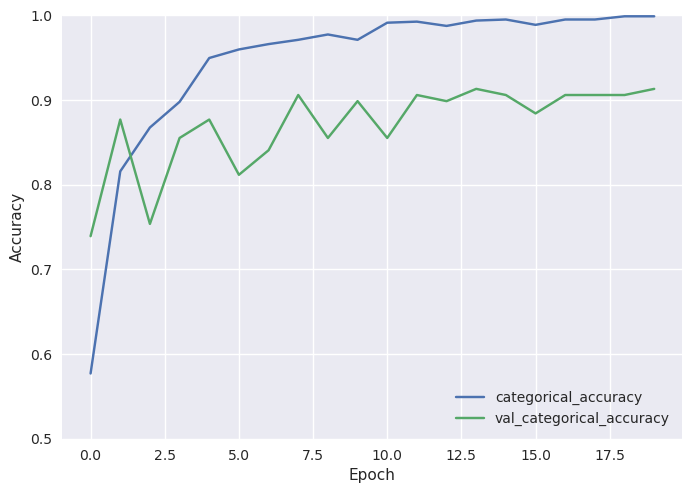

In [37]:
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

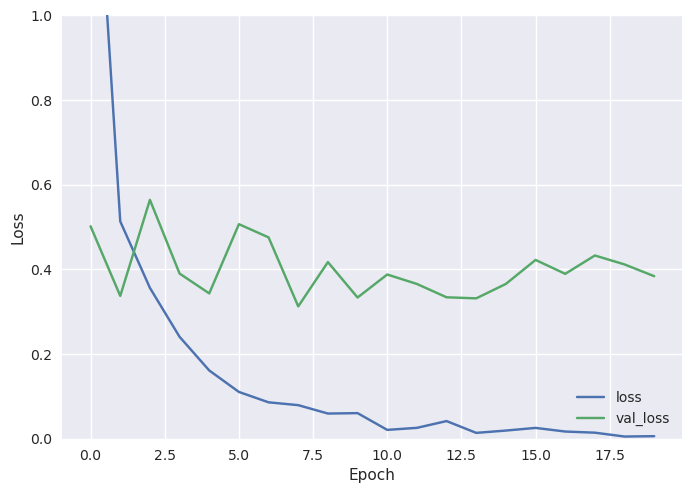

In [38]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [39]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)

2025-03-04 14:09:15.624045: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[60,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[60,1280,7,7]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1/1 - 21s - 21s/step - categorical_accuracy: 0.8500 - loss: 0.4296
0.8500000238418579


2025-03-04 14:10:24.351281: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1280,7,7]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


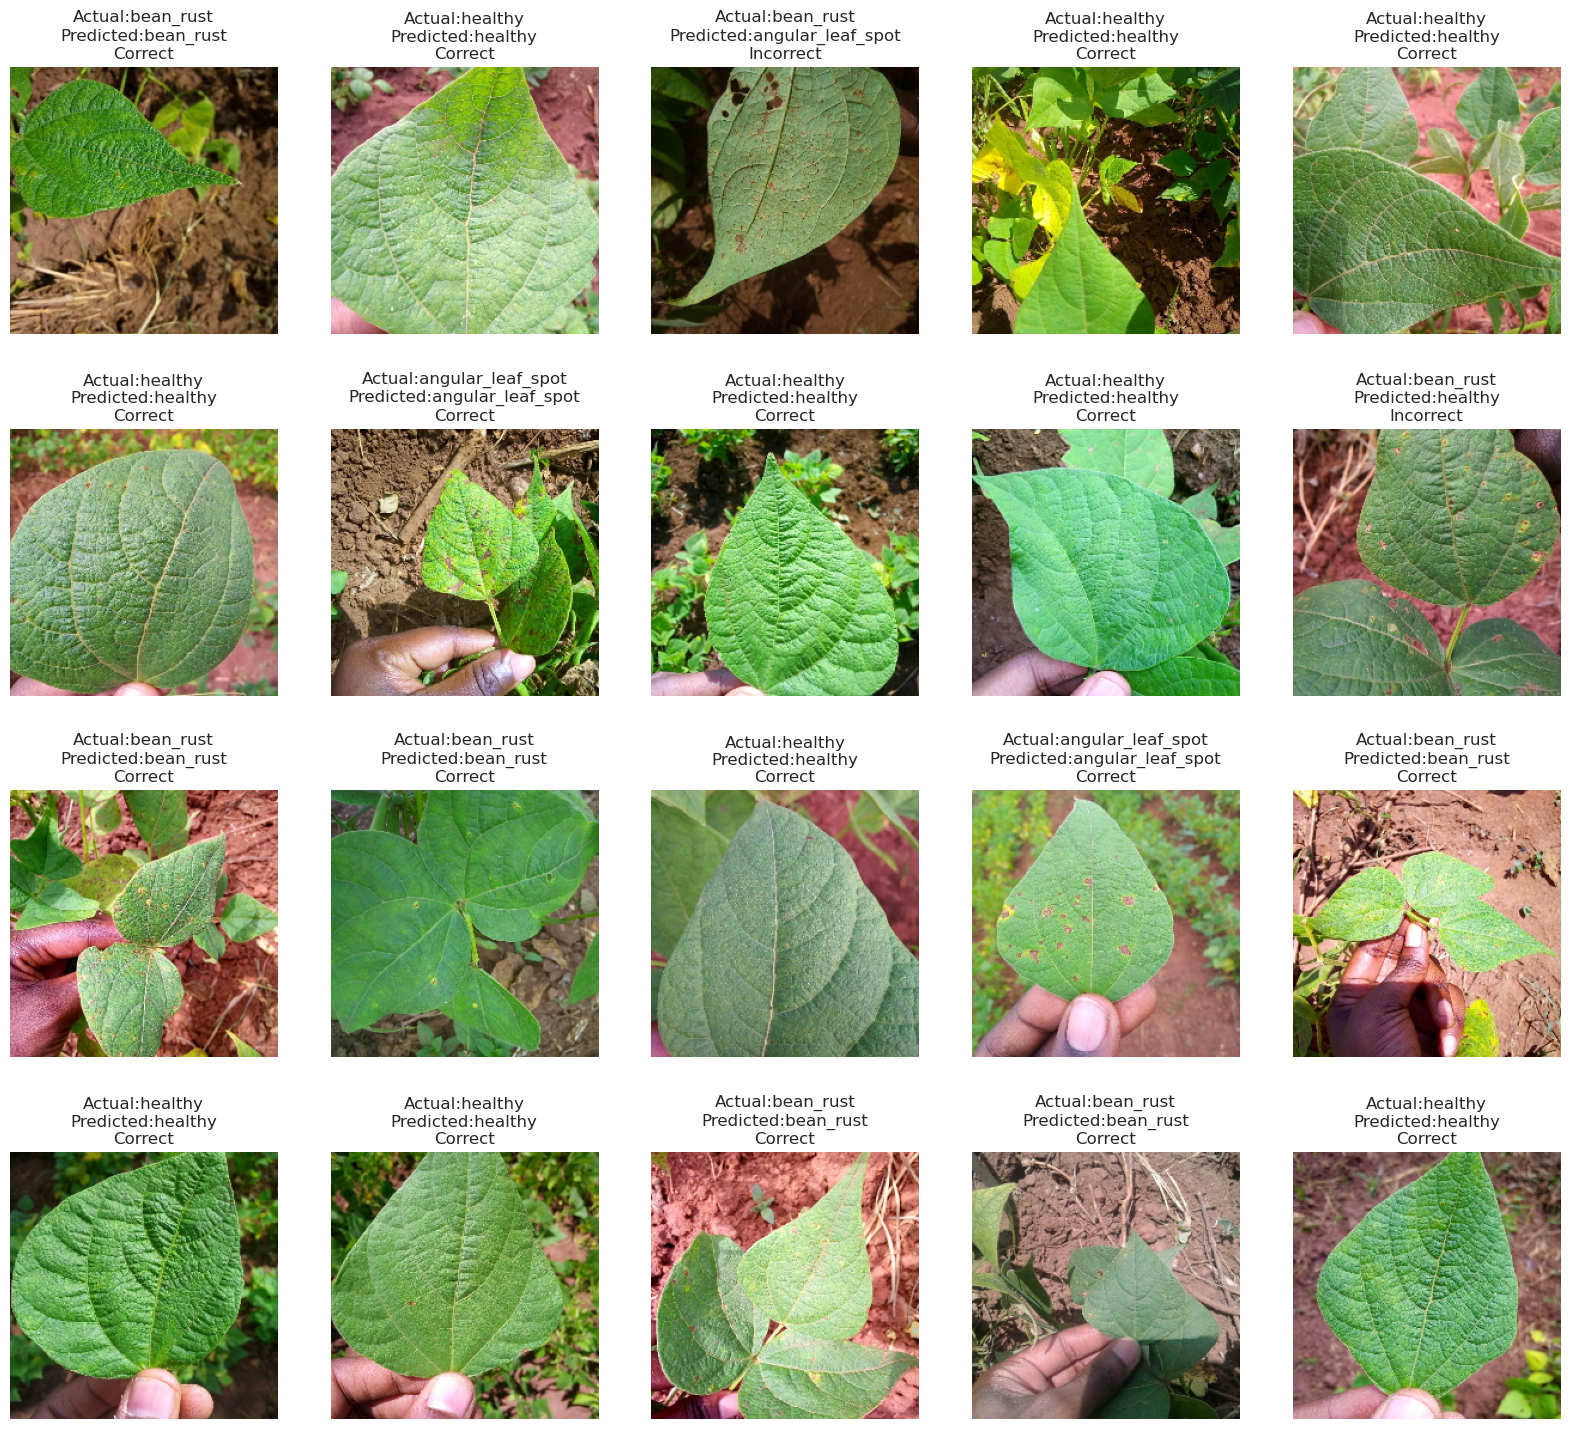

In [40]:
d_names = {
    0: 'bean_rust',
    1: 'healthy',
    2: 'angular_leaf_spot'
}

samples = df_test.sample(n = 20)

plt.figure(figsize = (20, 18))

for i in range(20):
    img = plt.imread(samples.iloc[i, 0])[:, :, :3]    
    img = op.resize(img, (224, 224))
    img2 = preprocess_input(img)
    img2 = np.resize(img2, (1, 224, 224, 3))
    pred = d_names[np.argmax(model.predict(img2), axis = 1)[0]]
    l = d_names[samples.iloc[i,1]]
    
    plt.subplot(4,5,i + 1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('Actual:{}\nPredicted:{}\n{}'.format(l, pred,  "Correct" if l == pred else "Incorrect"))
